In [30]:
#to check if CLIP is successfully installed
import sys
import site
print("Python version:", sys.version)
print("\nPython path:")
for path in sys.path:
    print(path)

print("\nInstalled packages:")
import pkg_resources
for package in pkg_resources.working_set:
    if "clip" in package.key.lower():
        print(f"{package.key} - Version: {package.version}")

try:
    import clip
    print("\nCLIP import successful!")
    print("Available models:", clip.available_models())
except ImportError as e:
    print("\nFailed to import CLIP:", e)

Python version: 3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 13:22:57) [Clang 14.0.6 ]

Python path:
/Users/adahe/opt/miniconda3/envs/cogs118b/lib/python312.zip
/Users/adahe/opt/miniconda3/envs/cogs118b/lib/python3.12
/Users/adahe/opt/miniconda3/envs/cogs118b/lib/python3.12/lib-dynload

/Users/adahe/opt/miniconda3/envs/cogs118b/lib/python3.12/site-packages
/Users/adahe/opt/miniconda3/envs/cogs118b/lib/python3.12/site-packages/setuptools/_vendor
/var/folders/xp/fxzznwj90lzg2gb9lcqcrm9w0000gn/T/tmpu_tk0rxn

Installed packages:
clip - Version: 1.0

CLIP import successful!
Available models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


### Imports


In [31]:
import torch
import clip
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision.datasets import CIFAR10
from torch.utils.data import Subset
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy

In [32]:
def load_vehicle_samples(num_samples_per_class=10):
    dataset = CIFAR10(root='./data', train=True, download=True)
    vehicle_classes = [0,1,8,9]
    
    # Get indices for each class
    class_indices = [[] for _ in range(10)]
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)
    
    # Randomly sample from each class
    selected_indices = []
    for class_idx in range(10):
        if class_idx not in vehicle_classes:
            continue
        selected_indices.extend(random.sample(class_indices[class_idx], num_samples_per_class))
    
    # Shuffle the selected indices
    random.shuffle(selected_indices)
    
    return Subset(dataset, selected_indices)


In [33]:
def get_clip_embeddings(images):
    # Load the model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    print(f"Model loaded successfully on {device}")
    
    # Initialize array to store embeddings
    embeddings = []
    labels = []
    
    # Process each image
    for img, label in images:
        # Convert PIL image to RGB if needed
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Preprocess and get embedding
        image_input = preprocess(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            image_features = model.encode_image(image_input)
            # Normalize the features
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            
        embeddings.append(image_features.cpu().numpy())
        labels.append(label)
    
    # Stack all embeddings into a single array
    embeddings = np.vstack(embeddings)
    labels = np.array(labels)
    
    return embeddings, labels

In [34]:
# Set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)

# Load 10 images from each class (100 total)
vehicle_samples = load_vehicle_samples(num_samples_per_class=10)

# Get embeddings
embeddings, labels = get_clip_embeddings(vehicle_samples)

print(f"\nEmbeddings shape: {embeddings.shape}")
print(f"Labels shape: {labels.shape}")
print(f"First few values of first embedding: {embeddings[0, :5]}")
print(f"Distribution of classes: {np.bincount(labels)}")

100%|██████████| 170M/170M [00:17<00:00, 9.62MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Model loaded successfully on cpu

Embeddings shape: (40, 512)
Labels shape: (40,)
First few values of first embedding: [-0.00872751  0.00433775 -0.02077864 -0.01509486 -0.01010078]
Distribution of classes: [10 10  0  0  0  0  0  0 10 10]


In [35]:
print(labels)

[1 1 1 0 9 1 8 0 8 9 9 1 9 0 8 0 8 8 9 9 0 9 9 0 1 1 1 8 8 0 1 0 8 0 9 8 0
 1 9 8]


#### Next, we perform hierarchical clustering on the embeddings

In [36]:
def plot_similarity_matrices(embeddings, labels):
    # CIFAR-10 class names - used later for labeling the plots
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                  'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Get label names
    label_names = [class_names[l] for l in labels]
    
    # Compute similarity matrix
    similarity_matrix = embeddings @ embeddings.T
    
    # Clustering
    # We use cosine similarity: ranges from -1 (very different) to 1 (very similar)
    # So by subtracting from 1, we now have distance from 0 (identical) to 2 (totally unrelated)
    distance_matrix = 1 - similarity_matrix 
    np.fill_diagonal(distance_matrix, 0) # Set diagonal to 0 because self-distance should be 0
    
    # For below: https://www.w3schools.com/python/python_ml_hierarchial_clustering.asp - "Ward" linkage is a type of linkage (indicates relatedness) based on euclid distance
    # And: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html 
    linkage_matrix = hierarchy.linkage(squareform(distance_matrix), method='ward')
    
    # sort data based on similarity
    # For below: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.leaves_list.html
    # This is so that we know how to reorder the labels
    clustering_order = hierarchy.leaves_list(linkage_matrix)
    
    # Create clustered version
    clustered_similarity = similarity_matrix[clustering_order][:, clustering_order]
    clustered_labels = [label_names[i] for i in clustering_order]
    
    # Create figure with two subplots (before and after clustering)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
    
    # Plot original similarity matrix
    sns.heatmap(similarity_matrix, 
                ax=ax1, 
                cmap='RdYlBu_r', 
                vmin=-1, 
                vmax=1,
                xticklabels=False,
                yticklabels=label_names,
                cbar_kws={'label': 'Similarity'})
    ax1.set_title('Original Similarity Matrix')
    ax1.tick_params(axis='y', rotation=0)
    
    # Plot clustered similarity matrix
    sns.heatmap(clustered_similarity, 
                ax=ax2, 
                cmap='RdYlBu_r', 
                vmin=-1, 
                vmax=1,
                xticklabels=False,
                yticklabels=clustered_labels,
                cbar_kws={'label': 'Similarity'})
    ax2.set_title('Clustered Similarity Matrix')
    ax2.tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()

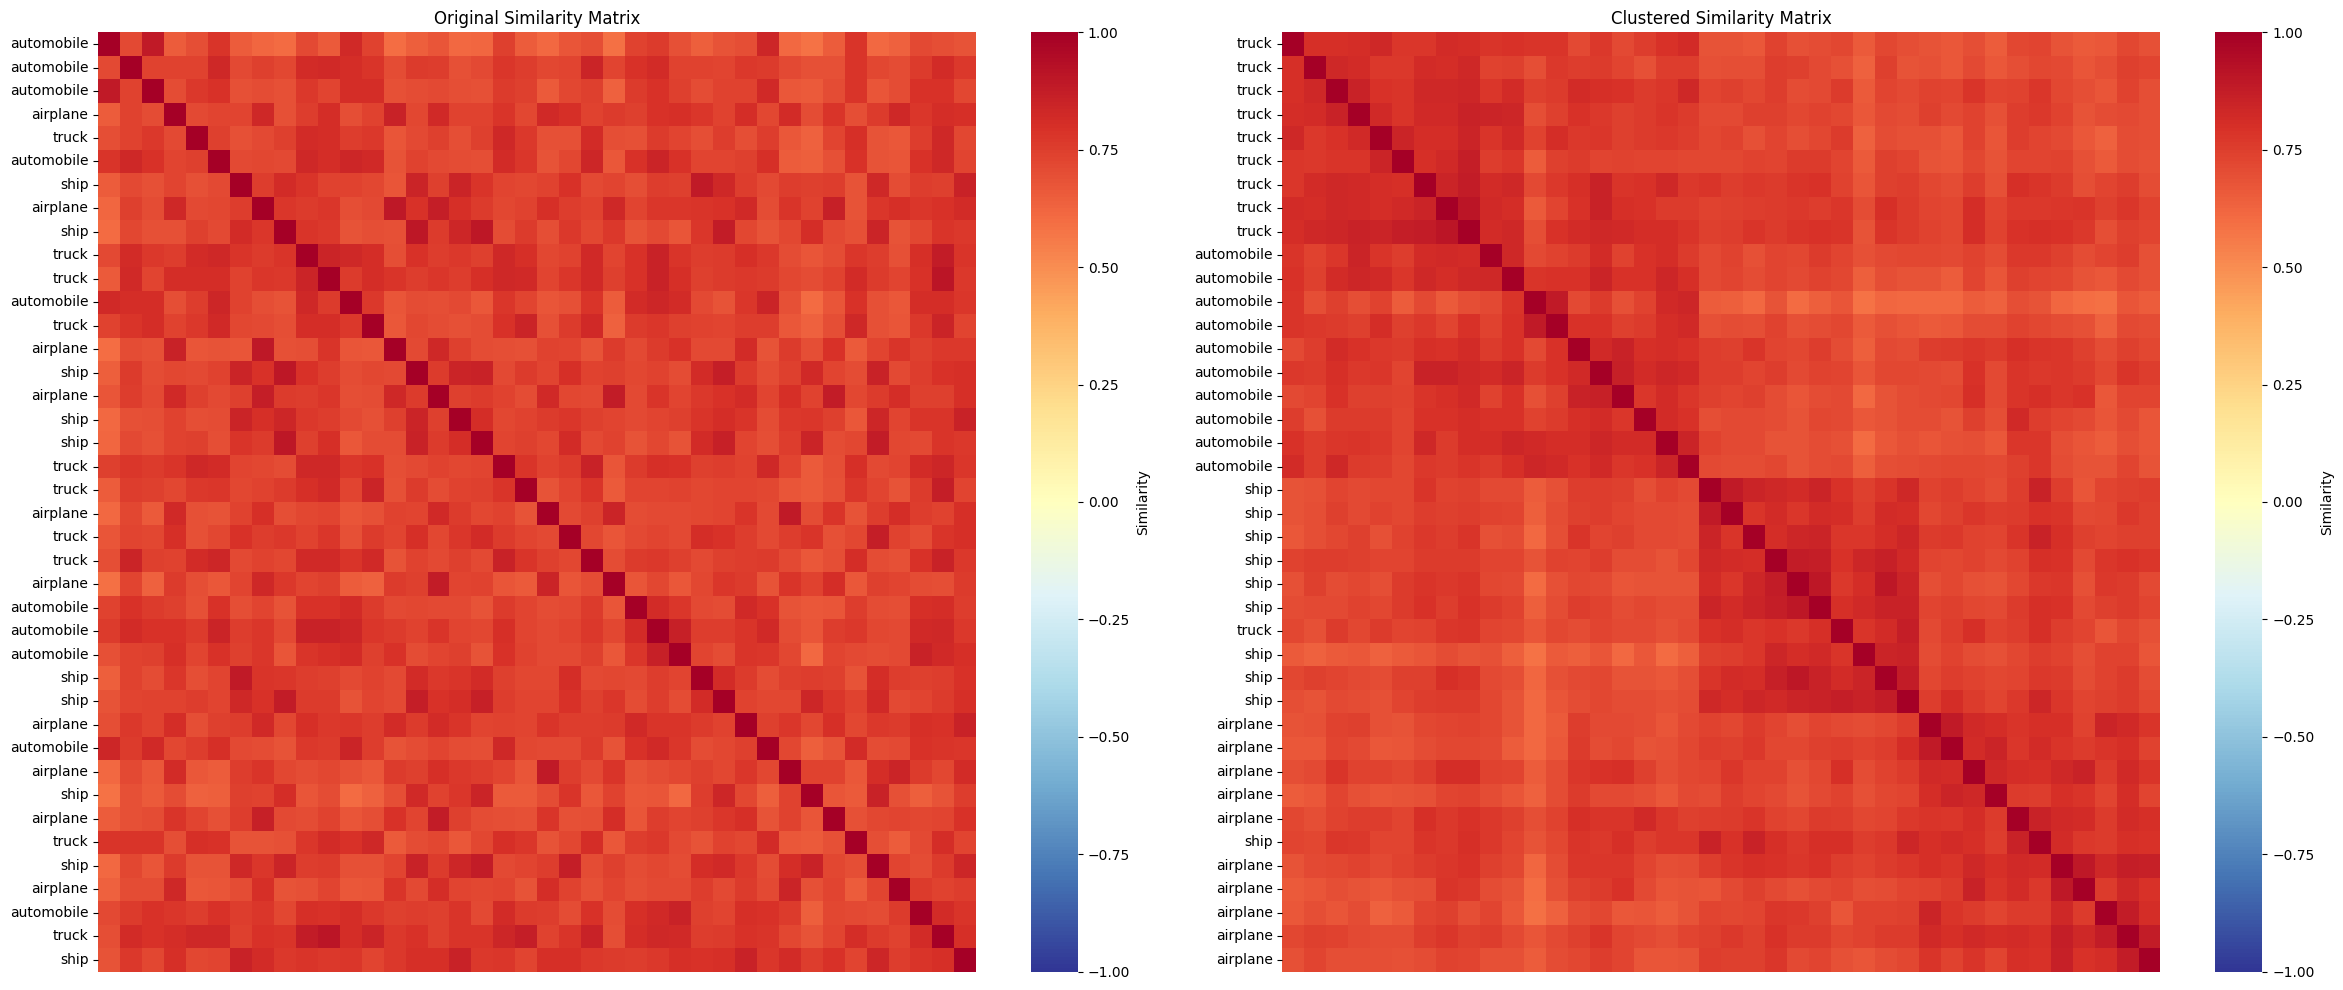

In [37]:
plot_similarity_matrices(embeddings, labels)